# Personality Predictor using Natural Language Processing and Tensorflow

### Importing the necessary libraries

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt

import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, Dropout, Conv1D, GlobalMaxPooling1D, GRU

import warnings
warnings.filterwarnings("ignore")

nltk.download("stopwords")
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Reading Data from drive

In [2]:
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
data = pd.read_csv("/content/drive/My Drive/mbti_1.csv")

### Observing the Data

In [4]:
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [5]:
data.isnull().sum()

type     0
posts    0
dtype: int64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [7]:
data.describe()

,type,posts
count,8675,8675
unique,16,8675
top,INFP,"'IMO, INTP for this doesn't make sense. As nob..."
freq,1832,1


In [8]:
types = np.unique(np.array(data['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [9]:
total = data.groupby(['type']).count()
total

,posts
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


### Graphing the counts of different Personalities available

Text(0.5, 1.0, 'Total posts for each personality type')

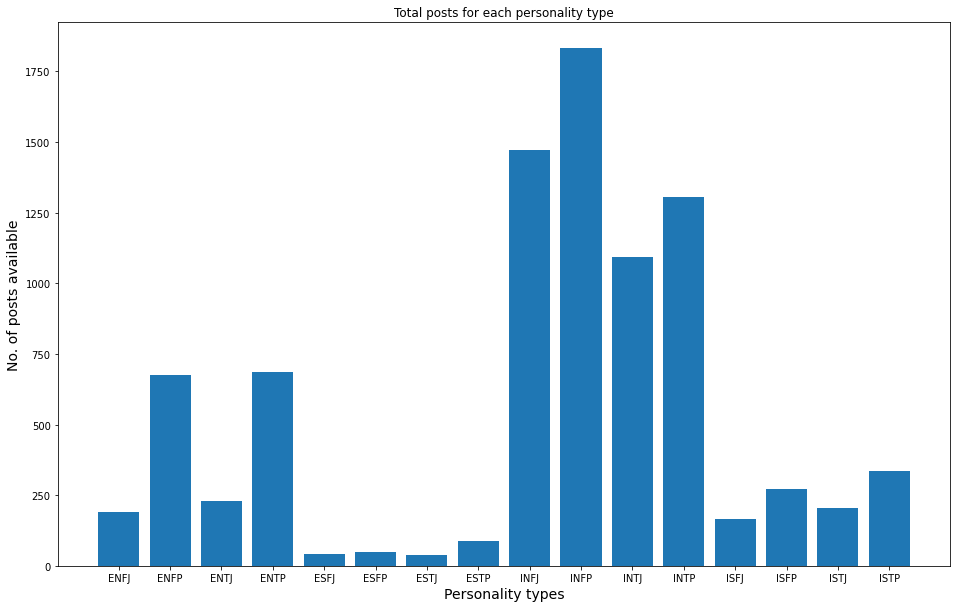

In [10]:
plt.figure(figsize = (16,10))
plt.bar(np.array(total.index), height = total['posts'],)
plt.xlabel('Personality types', size = 14)
plt.ylabel('No. of posts available', size = 14)
plt.title('Total posts for each personality type')

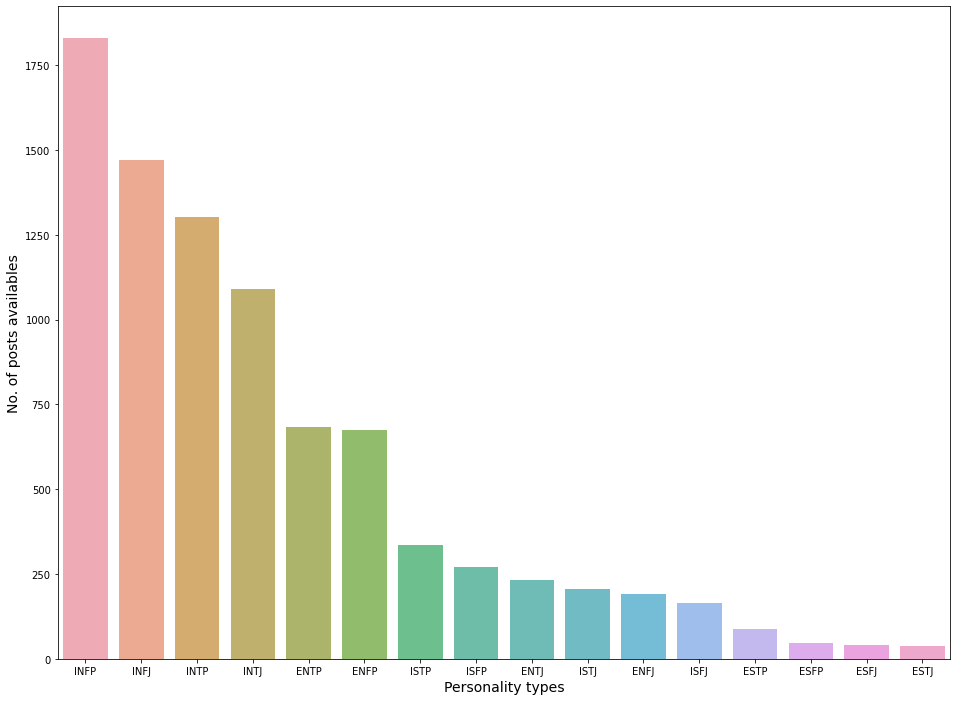

In [11]:
cnt_srs = data['type'].value_counts()
plt.figure(figsize=(16,12))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xlabel('Personality types', fontsize=14)
plt.ylabel('No. of posts availables', fontsize=14)
plt.show()

### Swarm Plot of characters in a post per personality

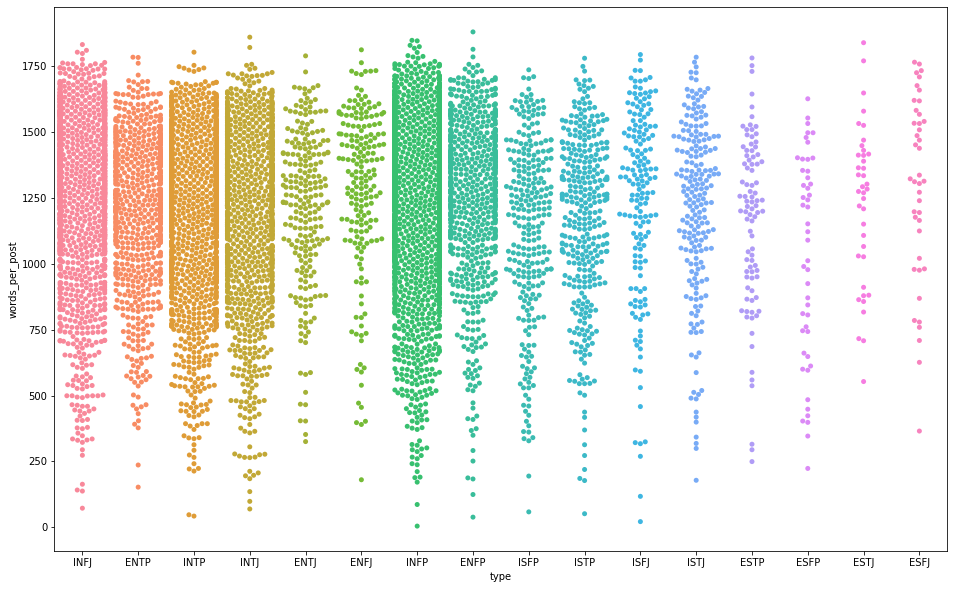

In [12]:
df = data.copy()
#this function counts the no of words in each post of a user
def var_row(row):
    l = []
    for i in row.split('|||'):
        l.append(len(i.split()))
    return np.var(l)

df['words_per_post'] = df['posts'].apply(lambda x: len(x.split()))
df['variance_of_word_counts'] = df['posts'].apply(lambda x: var_row(x))

plt.figure(figsize=(16,10))
sns.swarmplot("type", "words_per_post", data=df)

### Length of posts

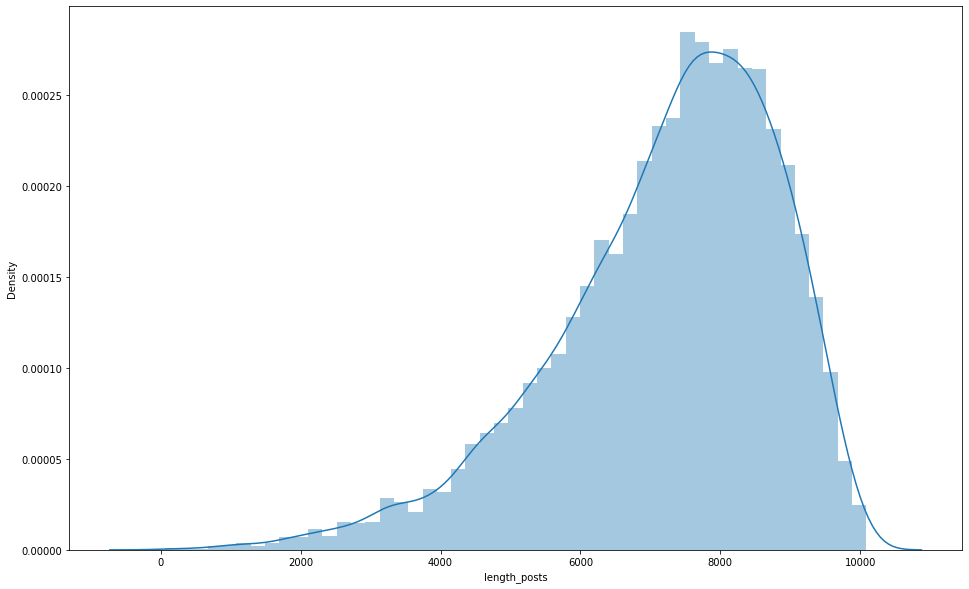

In [13]:
df["length_posts"] = df["posts"].apply(len)
plt.figure(figsize=(16,10))
sns.distplot(df["length_posts"])

### Displaying the top 10 Words

In [14]:
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(10)

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263)]

### Binarising the 4 Personality Traits

In [15]:
def get_types(row):
    t=row['type']

    E = 0; S = 0
    T = 0; P = 0
    
    if t[0] == 'I': E = 0
    elif t[0] == 'E': E = 1
        
    if t[1] == 'N': S = 0
    elif t[1] == 'S': S = 1
        
    if t[2] == 'T': T = 1
    elif t[2] == 'F': T = 0
        
    if t[3] == 'J': P = 0
    elif t[3] == 'P': P = 1
    return pd.Series( {'IE':E, 'NS':S , 'TF': T, 'JP': P })

In [16]:
data = data.join(data.apply (lambda row: get_types (row),axis=1))
data

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,0,1,0,1
8671,ENFP,'So...if this thread already exists someplace ...,1,0,0,1
8672,INTP,'So many questions when i do these things. I ...,0,0,1,1
8673,INFP,'I am very conflicted right now when it comes ...,0,0,0,1


### Counting personalities from each type

In [17]:
print ("Introversion (I) /  Extroversion (E):\t", data['IE'].value_counts()[0], " / ", data['IE'].value_counts()[1])
print ("Intuition (N) / Sensing (S):\t\t", data['NS'].value_counts()[0], " / ", data['NS'].value_counts()[1])
print ("Thinking (T) / Feeling (F):\t\t", data['TF'].value_counts()[0], " / ", data['TF'].value_counts()[1])
print ("Judging (J) / Perceiving (P):\t\t", data['JP'].value_counts()[0], " / ", data['JP'].value_counts()[1])

Introversion (I) /  Extroversion (E):	 6676  /  1999
Intuition (N) / Sensing (S):		 7478  /  1197
Thinking (T) / Feeling (F):		 4694  /  3981
Judging (J) / Perceiving (P):		 3434  /  5241


### Plotting the numbers

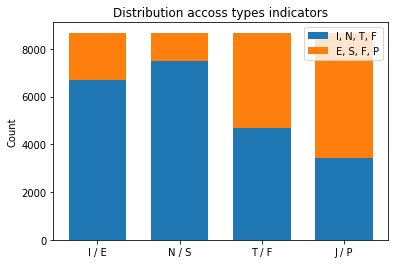

In [21]:
#Plotting the distribution of each personality type indicator
N = 4
bottom = (data['IE'].value_counts()[0], data['NS'].value_counts()[0], data['TF'].value_counts()[0], data['JP'].value_counts()[0])
top = (data['IE'].value_counts()[1], data['NS'].value_counts()[1], data['TF'].value_counts()[1], data['JP'].value_counts()[1])


ind = np.arange(N)    # the x locations for the groups
# the width of the bars
width = 0.7           # or len(x) can also be used here

p1 = plt.bar(ind, bottom, width, label="I, N, T, F")
p2 = plt.bar(ind, top, width, bottom=bottom, label="E, S, F, P") 


plt.title('Distribution accoss types indicators')
plt.ylabel('Count')
plt.xticks(ind, ('I / E',  'N / S', 'T / F', 'J / P',))
plt.legend()

plt.show()

### Understanding the Correlation of each personality trait with each other

In [22]:
data[['IE','NS','TF','JP']].corr()

,IE,NS,TF,JP
IE,1.000000,-0.045899,0.069573,0.161939
NS,-0.045899,1.000000,0.080954,0.014922
TF,0.069573,0.080954,1.000000,0.004673
JP,0.161939,0.014922,0.004673,1.000000


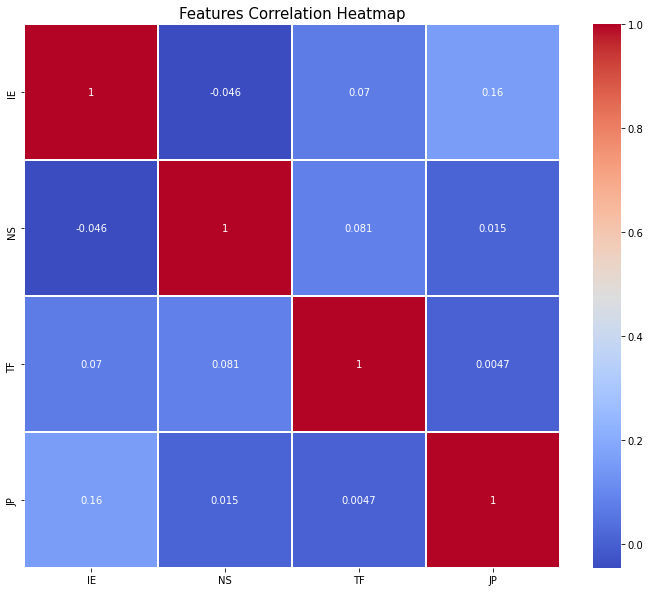

In [23]:
cmap = plt.cm.coolwarm
corr = data[['IE','NS','TF','JP']].corr()
plt.figure(figsize=(12,10))
plt.title('Features Correlation Heatmap', size=15)
sns.heatmap(corr, cmap=cmap, annot=True, linewidths=1)

### Preprocessing the Data

#### Removing the useless words and URLs from the posts

In [24]:
lemmatiser = WordNetLemmatizer()

# Remove the stop words for speed 
useless_words = stopwords.words("english")

# Remove these from the posts
unique_type_list = ['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ']
unique_type_list = [x.lower() for x in unique_type_list]

In [25]:
# Splitting the MBTI personality into 4 letters and binarizing it

b_Pers = {'I':0, 'E':1, 'N':0, 'S':1, 'F':0, 'T':1, 'J':0, 'P':1}
b_Pers_list = [{0:'I', 1:'E'}, {0:'N', 1:'S'}, {0:'F', 1:'T'}, {0:'J', 1:'P'}]

def translate_personality(personality):
    # transform mbti to binary vector
    return [b_Pers[l] for l in personality]

#To show result output for personality prediction
def translate_back(personality):
    # transform binary vector to mbti personality
    s = ""
    for i, l in enumerate(personality):
        s += b_Pers_list[i][l]
    return s

In [26]:
def pre_process_text(df, remove_stop_words=True, remove_mbti_profiles=True):
  list_personality = []
  list_posts = []
  len_df = len(df)
  i=0
  
  for row in df.iterrows():
      #Remove and clean comments
      posts = row[1].posts

      #Remove url links 
      temp = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

      #Remove Non-words - keep only words
      temp = re.sub("[^a-zA-Z]", " ", temp)

      # Remove spaces > 1
      temp = re.sub(' +', ' ', temp).lower()

      #Remove stop words
      if remove_stop_words:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ') if w not in useless_words])
      else:
          temp = " ".join([lemmatiser.lemmatize(w) for w in temp.split(' ')])
          
      #Remove MBTI personality words from posts
      if remove_mbti_profiles:
          for t in unique_type_list:
              temp = temp.replace(t,"")

      # transform mbti to binary vector
      type_labelized = translate_personality(row[1].type) #or use lab_encoder.transform([row[1].type])[0]
      list_personality.append(type_labelized)
      # the cleaned df temp is passed here
      list_posts.append(temp)

  # returns the result
  list_posts = np.array(list_posts)
  list_personality = np.array(list_personality)
  return list_posts, list_personality

In [27]:
list_posts, list_personality  = pre_process_text(data)

### Tokenizing the words and coverting them to sequences

##### Setting the variables

In [28]:
vocab_size = 10000
maxlen = 1500
trunc_type = "post"
pad_type = "post"
oov_tok = "<OOV>"
embedding_dim = 256

In [29]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(list_posts)

word_index = tokenizer.word_index

In [30]:
sequences = tokenizer.texts_to_sequences(list_posts)
sequences_padded = pad_sequences(sequences, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

### Setting up the TPU

In [31]:
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

INFO:tensorflow:Initializing the TPU system: grpc://10.119.203.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.119.203.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


### Setting the 4 Personality Traits

In [32]:
personality_type = ["IE: Introversion (I) / Extroversion (E)",
                    "NS: Intuition (N) / Sensing (S)",
                    "FT: Feeling (F) / Thinking (T)",
                    "JP: Judging (J) / Perceiving (P)"]

### Creating the Model and making a Graphing Function

In [33]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [35]:
def create_model():
    model = Sequential()
    model.add(Embedding(10000, embedding_dim, input_length=maxlen))    
    
    model.add(GRU(256, return_sequences=True))
    model.add(GRU(128, return_sequences=True))
    model.add(GRU(64, return_sequences=True))
    model.add(Flatten())

    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

    return model

#### Running the model for 50 Epochs

Epoch 1/50
174/174 [==============================] - 99s 502ms/step - loss: 0.5724 - accuracy: 0.7584 - val_loss: 0.7475 - val_accuracy: 0.7622
Epoch 2/50
174/174 [==============================] - 80s 460ms/step - loss: 0.4309 - accuracy: 0.8065 - val_loss: 0.5374 - val_accuracy: 0.7601
Epoch 3/50
174/174 [==============================] - 80s 459ms/step - loss: 0.2117 - accuracy: 0.9197 - val_loss: 0.8190 - val_accuracy: 0.7637
Epoch 4/50
174/174 [==============================] - 80s 459ms/step - loss: 0.0507 - accuracy: 0.9808 - val_loss: 1.6597 - val_accuracy: 0.7651
Epoch 5/50
174/174 [==============================] - 80s 460ms/step - loss: 0.0492 - accuracy: 0.9824 - val_loss: 1.5600 - val_accuracy: 0.7594
Epoch 6/50
174/174 [==============================] - 80s 460ms/step - loss: 0.0250 - accuracy: 0.9914 - val_loss: 1.9999 - val_accuracy: 0.7457
Epoch 7/50
174/174 [==============================] - 80s 460ms/step - loss: 0.0302 - accuracy: 0.9909 - val_loss: 2.0376 - val_ac

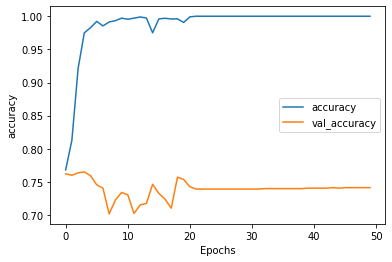

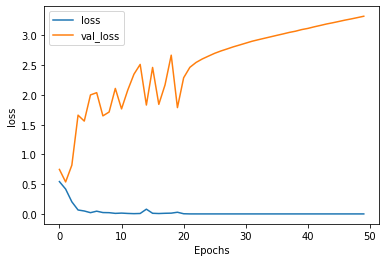

IE: Introversion (I) / Extroversion (E) Accuracy: 75.10%
Epoch 1/50
196/196 [==============================] - 108s 497ms/step - loss: 0.4600 - accuracy: 0.8603 - val_loss: 0.3555 - val_accuracy: 0.8631
Epoch 2/50
196/196 [==============================] - 89s 454ms/step - loss: 0.2554 - accuracy: 0.8892 - val_loss: 0.3614 - val_accuracy: 0.8631
Epoch 3/50
196/196 [==============================] - 89s 455ms/step - loss: 0.1516 - accuracy: 0.9445 - val_loss: 0.4562 - val_accuracy: 0.8300
Epoch 4/50
196/196 [==============================] - 89s 455ms/step - loss: 0.0742 - accuracy: 0.9762 - val_loss: 0.7604 - val_accuracy: 0.7291
Epoch 5/50
196/196 [==============================] - 89s 454ms/step - loss: 0.0817 - accuracy: 0.9721 - val_loss: 1.0280 - val_accuracy: 0.8415
Epoch 6/50
196/196 [==============================] - 89s 455ms/step - loss: 0.0404 - accuracy: 0.9844 - val_loss: 0.9281 - val_accuracy: 0.8285
Epoch 7/50
196/196 [==============================] - 89s 455ms/step - l

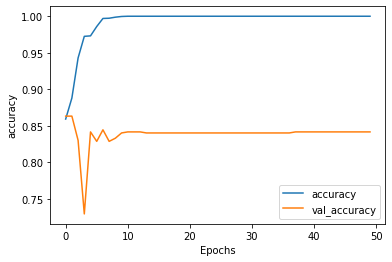

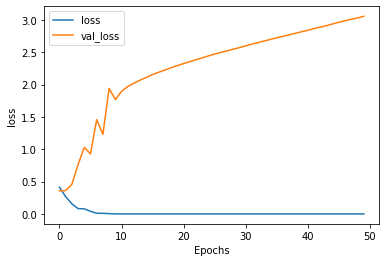

NS: Intuition (N) / Sensing (S) Accuracy: 85.65%
Epoch 1/50
196/196 [==============================] - 108s 492ms/step - loss: 0.6927 - accuracy: 0.5273 - val_loss: 0.4971 - val_accuracy: 0.7478
Epoch 2/50
196/196 [==============================] - 89s 454ms/step - loss: 0.4371 - accuracy: 0.8069 - val_loss: 0.4963 - val_accuracy: 0.7579
Epoch 3/50
196/196 [==============================] - 89s 454ms/step - loss: 0.2572 - accuracy: 0.9039 - val_loss: 0.5010 - val_accuracy: 0.7695
Epoch 4/50
196/196 [==============================] - 89s 454ms/step - loss: 0.1832 - accuracy: 0.9289 - val_loss: 0.6483 - val_accuracy: 0.7536
Epoch 5/50
196/196 [==============================] - 89s 455ms/step - loss: 0.0976 - accuracy: 0.9612 - val_loss: 0.8262 - val_accuracy: 0.7349
Epoch 6/50
196/196 [==============================] - 89s 455ms/step - loss: 0.0297 - accuracy: 0.9892 - val_loss: 1.4455 - val_accuracy: 0.7133
Epoch 7/50
196/196 [==============================] - 89s 455ms/step - loss: 0.0

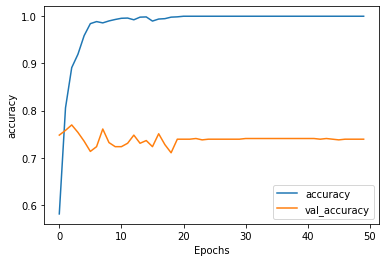

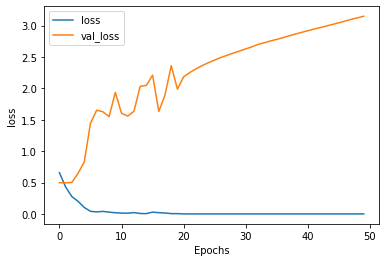

FT: Feeling (F) / Thinking (T) Accuracy: 76.37%
Epoch 1/50
174/174 [==============================] - 98s 503ms/step - loss: 0.6913 - accuracy: 0.5648 - val_loss: 0.6608 - val_accuracy: 0.5994
Epoch 2/50
174/174 [==============================] - 80s 460ms/step - loss: 0.6491 - accuracy: 0.6326 - val_loss: 0.6589 - val_accuracy: 0.6376
Epoch 3/50
174/174 [==============================] - 80s 460ms/step - loss: 0.4001 - accuracy: 0.8218 - val_loss: 0.7503 - val_accuracy: 0.6081
Epoch 4/50
174/174 [==============================] - 80s 460ms/step - loss: 0.1127 - accuracy: 0.9634 - val_loss: 1.6347 - val_accuracy: 0.6182
Epoch 5/50
174/174 [==============================] - 80s 461ms/step - loss: 0.0397 - accuracy: 0.9871 - val_loss: 1.7178 - val_accuracy: 0.5944
Epoch 6/50
174/174 [==============================] - 80s 461ms/step - loss: 0.0377 - accuracy: 0.9860 - val_loss: 1.7650 - val_accuracy: 0.6037
Epoch 7/50
174/174 [==============================] - 80s 461ms/step - loss: 0.041

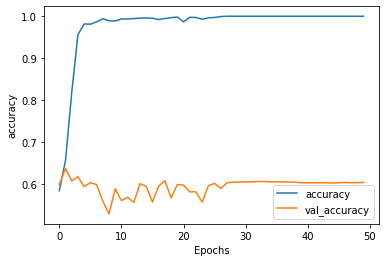

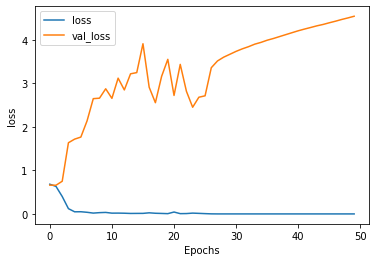

JP: Judging (J) / Perceiving (P) Accuracy: 62.94%


In [36]:
train_val_split = [0.2, 0.1, 0.1, 0.2]
for l in range(len(personality_type)):

    with strategy.scope():
        model = create_model()

    Y = list_personality[:,l]

    # split data into train, val and test sets
    X_train, X_test, y_train, y_test = train_test_split(sequences_padded, Y, test_size=0.2, random_state=101)
    X_train, val, y_train, y_val = train_test_split(X_train, y_train, test_size=train_val_split[l], random_state=101)
    
    history = model.fit(X_train, y_train,
                        epochs=50,
                        validation_data=(val, y_val),
                        verbose=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")

    model.save("model"+str(l)+".h5")
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], test_accuracy * 100.0))

#### Running and saving model according to the graph inference

Epoch 1/2
174/174 [==============================] - 99s 508ms/step - loss: 0.5634 - accuracy: 0.7579 - val_loss: 0.5295 - val_accuracy: 0.7601
Epoch 2/2
55/55 [==============================] - 3s 48ms/step - loss: 0.5418 - accuracy: 0.7758


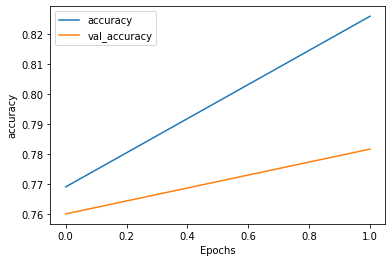

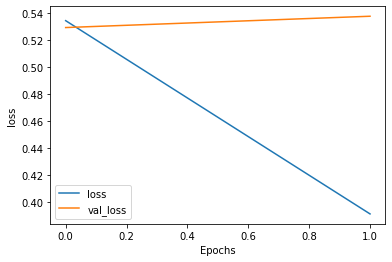

IE: Introversion (I) / Extroversion (E) Accuracy: 77.58%
55/55 [==============================] - 4s 64ms/step - loss: 0.3814 - accuracy: 0.8715


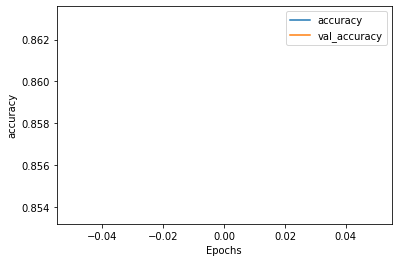

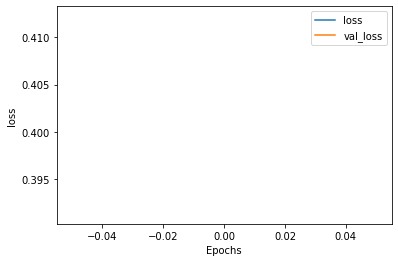

NS: Intuition (N) / Sensing (S) Accuracy: 87.15%
Epoch 1/2
196/196 [==============================] - 108s 493ms/step - loss: 0.6795 - accuracy: 0.5778 - val_loss: 0.4618 - val_accuracy: 0.7824
Epoch 2/2
55/55 [==============================] - 4s 66ms/step - loss: 0.4749 - accuracy: 0.7660


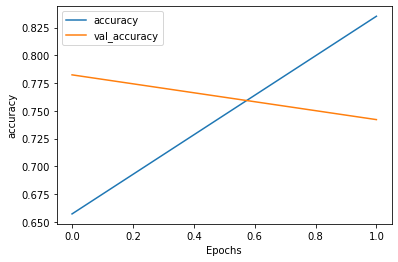

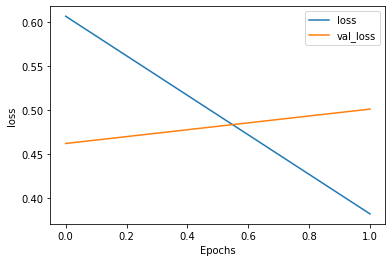

FT: Feeling (F) / Thinking (T) Accuracy: 76.60%
Epoch 1/3
174/174 [==============================] - 98s 502ms/step - loss: 0.6910 - accuracy: 0.5791 - val_loss: 0.6883 - val_accuracy: 0.5965
Epoch 2/3
174/174 [==============================] - 80s 461ms/step - loss: 0.6716 - accuracy: 0.5988 - val_loss: 0.8830 - val_accuracy: 0.4885
Epoch 3/3
55/55 [==============================] - 3s 49ms/step - loss: 0.6462 - accuracy: 0.6611


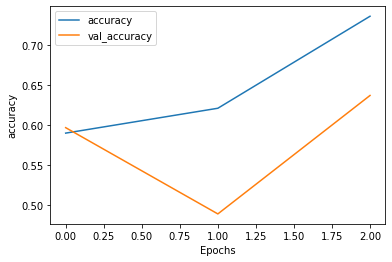

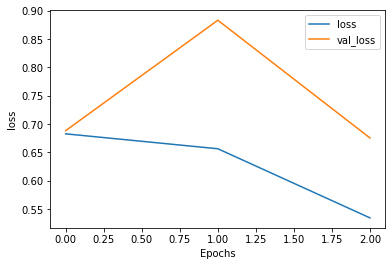

JP: Judging (J) / Perceiving (P) Accuracy: 66.11%


In [37]:
num_epochs = [2, 1, 2, 3]
train_val_split = [0.2, 0.1, 0.1, 0.2]
model_names = ["model_IE.h5", "model_NS.h5", "model_FT.h5", "model_JP.h5"]

for l in range(len(personality_type)):

    with strategy.scope():
        model = create_model()

    Y = list_personality[:,l]

    # split data into train, val and test sets
    X_train, X_test, y_train, y_test = train_test_split(sequences_padded, Y, test_size=0.2, random_state=101)
    X_train, val, y_train, y_val = train_test_split(X_train, y_train, test_size=train_val_split[l], random_state=101)
    
    history = model.fit(X_train, y_train,
                        epochs=num_epochs[l],
                        validation_data=(val, y_val),
                        verbose=1)

    test_loss, test_accuracy = model.evaluate(X_test, y_test)

    plot_graphs(history, "accuracy")
    plot_graphs(history, "loss")

    model.save(model_names[l])
    
    print("%s Accuracy: %.2f%%" % (personality_type[l], test_accuracy * 100.0))

In [39]:
modelIE = load_model("model_IE.h5")
modelNS = load_model("model_NS.h5")
modelFT = load_model("model_FT.h5")
modelJP = load_model("model_JP.h5")

### Defining function to decode the binary coding

In [40]:
def predictIE(prediction):
    p = round(prediction[0][0])
    if p == 0:
        return 'I'
    else:
        return 'E'

def predictNS(prediction):
    p = round(prediction[0][0])
    if p == 0:
        return 'N'
    else:
        return 'S'

def predictFT(prediction):
    p = round(prediction[0][0])
    if p == 0:
        return 'F'
    else:
        return 'T'

def predictJP(prediction):
    p = round(prediction[0][0])
    if p == 0:
        return 'J'
    else:
        return 'P'

### Making a function to predict the personality

In [41]:
def presonality_prediction(post):
    sample_data = pd.DataFrame(data={'type': "INTJ", 'posts': [post]})
    clean_sample, _ = pre_process_text(sample_data)

    tokenizer.fit_on_texts(clean_sample)
    sample_sequence = tokenizer.texts_to_sequences(clean_sample)
    sample_sequence_padded = pad_sequences(sample_sequence, maxlen = maxlen, truncating = trunc_type, padding = pad_type)

    final_pred = predictIE(modelIE.predict(sample_sequence_padded)) + predictNS(modelNS.predict(sample_sequence_padded)) + predictFT(modelFT.predict(sample_sequence_padded)) + predictJP(modelJP.predict(sample_sequence_padded))
    
    return final_pred

### Checking Few Predictions

In [44]:
my_post  = """ Hi I am 21 years, currently, I am pursuing my graduate degree in 
computer science and management (Mba Tech CS ), It is a 5-year dual degree.... 
My CGPA to date is 3.8/4.0 . I have a passion for teaching since childhood. Math
 has always been the subject of my interest in school. Also, my mother has been 
 one of my biggest inspirations for me. She started her career as a teacher and 
 now has her own education trust with preschools schools in Rural and Urban 
 areas. During the period of lockdown, I dwelled in the field of blogging and 
 content creation on Instagram.  to spread love positivity kindness . I hope I 
 am able deliver my best to the platform and my optimistic attitude helps in the
  growth that is expected. Thank you for the opportunity. """

In [45]:
presonality_prediction(my_post)

'INTP'

In [46]:
my_post  = """ I dont think anyone would be able to live 300 years i am not talking about the physical ability to do so but the mental fortitude unless you decide to live away from civilization it simply is not possible.|||Believe me you would not want to live for that long alone , unless there are others who can live for 300 years as well.|||You cannot enjoy something if you say something to yourself like ‘I wanna enjoy this , i think this thing is gonna be fun’ believe me it doesn’t work.|||I think this problem might be face by a lot of people.|||Firstly you should only study stuff that interests you . (obvious)|||Now there are subjects that you school forces you to take and you have no option but to some how score in those subjects. (What i used to think is subjects like history , geography and most of all Hindi are utterly useless , i wanna be a programmer why do i study these)|||But because i had no choice i thought lets give these a try. I started questioning things and when i dug deep into the events of history and and why each event took place or how it was of benefit to the benefactor. This questioning and finding out the reasons made me like history.|||My point is unless ya’ll start questioning and researching further than whats necessary for exams you wont like that subject. All the subjects are beautiful , its what you choose to see. Basically give everything a real shot in life , everything works out. (my advice seems ironical as if you dont like the subject and i am telling you to research further but try it once )|||And also never study because there is exam or because you have to do an assignment or because someone is told you to or because ….|||But please ONLY STUDY BECAUSE YOU FEEL LIKE AND BECAUSE YOU WANT TO. Until you develop this sense of want to study it will be hard for you to like it. You must like it so much , that you know when people say after studying maths for 1 hour they took a break of 20 mins watching their favorite tv show(lets say friends)|||For you it should be like after 1 hour of x(that you dont like but HAVE to do) activity you take a break of 20 mins and you study , (like i like reading article on ai so i do that) you might like bio you will do that what i want to say is that is what it means to like something and only then you can truly enjoy it.|||If only something known as luck existed. (no offence to the readers or person who asked the question)|||Luck is a really interesting term , a really complex illusion. What i am saying is there is nothing known as luck that exists. Something simply doesnt just happen. It happens for a reason and with a reason.|||Some over here might claim that if it is not luck then what is it that cause (cause a child to be born in a rich family or a person to be saved by weirdest phenomenon and escape death.)|||What i want ya’ll to know is firstly that being born rich cannot be called as “lucky” like we cannot say to be born in a rich family is particularly a good thing there are many reasons to this (some people like to work their way up , Some want to experience the life troubles, well whatever the reasons might be) So firstly when we say something to be lucky we just CONSIDER that what happened was good. Same goes with the case of being saved from and awful accident. We still dont know the purpose of life or our existence and hence we dont know if living is a boon. this might be harsh for some but Reality is Harsh.|||What want ya’ll to know is never feel bad if something good(in your perspective) happens to someone as It might as well not turn out to be good if you see the BIG picture.|||Besides its also a good thing to think this way as its boosts up your hopes , like you might consider that everything that has happened to you has made you what you are and even if you don’t appreciate your conditions there is someone somewhere who would want to be in that.|||I think the all of us are 100% selfish. (no offence)|||The thing is even if we say we care about someone and then we help that person in reality we are just making ourselves happy by helping that someone.|||What i mean to say is even when people talk about sacrifices for others the reality is that sacrifice made that person or those persons happy which you cared for and thus those people being happy makes you happy.|||Everything comes down to you. You can try and deny it but you all know it.|||Now about those people who sacrifice their lives for others that is a peculiar case , and here too (this might be hard for some to believe) but they sacrifice life for someone they loved (they thought they loved) but the truth is in a situation where a person sacrifices his life for another the truth is that if he hadnt dont that he couldn’t have survived without that person anyways and then there are always some who seek glory.|||I hope you get the point. Even when you say that people spend 30s and 40s the truth is making their kids life perfect gives them happiness. There are people without kids too cause for these making their kids life perfect doesnt give them as much happiness as focusing on their own goals might.|||Now i believe there might be many who thought that making kids life perfect might give them happiness but it turns out to be false and then they are stuck there fulfilling moral obligations. It all comes down to your resolves and how firm you are in you decisions.|||Isn’t it fun to watch our disciples fight among themselves to prove that only one of us exists!|||I tend to believe that everything in this universe HAS TO HAVE A PURPOSE. Rather than thinking that the universe is a useless place and we have no purpose i would rather think we are just too stupid and dont know or cannot find the purpose. I have always wondered that what would be our reason to exist , once i thought of us (humans on earth) a crop created by aliens that takes this long to grow (i mean may be it would be not possible to create humans by a process other than evolution) so the aliens started the life on earth and are now just waiting for us to evolve , and so our purpose according to that is nothing but to serve as food or may be what ever they want , now then the question arises is what would their purpose be , And all such hypothetical situation lead to to scenario to go into infinity.|||After a lot of such crazy thought i came to 2 conclusions , 1 is pretty simple our purpose of life is find a purpose for our lives , and the weird thing is unlike other things once you find what your were looking for , the process ends there. The paradox is after you find your purpose of life did your succeed in finishing your purpose of life or did you just begun ?|||The 2nd one is what most people should agree is happiness. Now I think that this happiness should be confined to YOUR’s and ONLY your Happiness. Now the thing is some people gain happiness by giving people happiness.|||Let happiness be a quantifiable entity. We shall say that we start 0 oh hp . |||The zone where we dont feel happy or sad is 0 . Anything above 0 means you are happy and less than 0 is you are sad .|||Now one might think that if we suppose attain 100 hp , and do nothing after that we shall remain happy , the problem is that after a while our bar above which we remain moves up (simple adaptation) so now anything below 100hp is sad . This is the main problem with happiness , and So we need to keep doing stuff and increasing our hp . So maybe this counts as a purpose of life.|||Like when we are told about those saints and stuff who abandon society and live their life alone in discrete places where no one can disturb them. I believe the simple reason for this they have found happiness in doing nothing . Like someone finds happiness in making more money (there is a possibility that you might not make and hence be sad ) So these saint type people do something that has no opposite , like i know when they do nothing (i know its opposite is everything) and thats the very reason they go away from the civilization where they literally will have to do nothing . I also tend to think of these people as cowards who fear that they might loose at point.|||But the very point arises is what did you gain by gaining happiness. So again there is no end so Keep chasing the infinity its pointless but Keeps you busy(till the point you are alive) then after you are dead i guess nothing matters.|||But anyways thats the most easy thing to obtain happiness without sadness.|||But the very point arises is what did you gain by gaining happiness. So again there is no end so Keep chasing the infinity its pointless but Keeps you busy(till the point you are alive) then after you are dead i guess nothing matters.|||But if the life after death theory is true , and if by chance are memories are also transferred every time we are reborn. We all are fucked We are for infinity stuck chasing the infinity . (I wonder what happens when infinity chases infinity It will be fun to watch !) |||I think rather than worrying about these things we should just enjoy life . Because there will always something that we dont know that we dont know and thus we shall never know that. this is just 2 loops of not know , you can reach it , but Do it infinitely . Infinity is a bitch.|||Well To all beings good luck finding a purpose and to all those who know that it doesnt exist ya’ll are fucked."""

In [47]:
presonality_prediction(my_post)

'INTJ'

In [55]:
my_post = """ They act like they care They tell me to share But when I carve the stories on my arm The doctor just calls it self harm I’m not asking for attention There’s a reason I have apprehensions I just need you to see What has become of me||| I know I’m going crazy But they think my thoughts are just hazy When in that chaos, in that confusion I’m crying out for help, to escape my delusions||| Mental health is a state of mind How does one keep that up when assistance is denied All my failed attempts to fight the blaze You treat it like its a passing phase||| Well stop, its not, because mental illness is real Understand that we’re all not made of steel Because when you brush these issues under the carpet You make it seem like its our mistake we’re not guarded||| Don’t you realise that its a problem that needs to be addressed Starting at home, in our nest Why do you keep your mouths shut about such things Instead of caring for those with broken wings||| What use is this social stigma When mental illness is not even such an enigma Look around and you’ll see the numbers of the affected hiding under the covers ||| This is an issue that needs to be discussed Not looked down upon with disgust Mental illness needs to be accepted So that people can be protected ||| Let me give you some direction People need affection The darkness must be escaped Only then the lost can be saved||| Bring in a change Something not very strange The new year is here Its time to eradicate fear||| Recognise the wrists under the knives To stop mental illness from taking more lives Let’s break the convention Start ‘suicide prevention’.||| Hoping the festival of lights drives the darkness of mental illness away"""

In [57]:
presonality_prediction(my_post)

'INTP'

### Checking on Original Dataset

In [48]:
data

,type,posts,IE,NS,TF,JP
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0,0,0,0
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,1
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,1
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,0
4,ENTJ,'You're fired.|||That's another silly misconce...,1,0,1,0
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,0,1,0,1
8671,ENFP,'So...if this thread already exists someplace ...,1,0,0,1
8672,INTP,'So many questions when i do these things. I ...,0,0,1,1
8673,INFP,'I am very conflicted right now when it comes ...,0,0,0,1


In [66]:
t = data.posts.values[2]

In [67]:
presonality_prediction(t)

'INFP'

As we can see, the model predicts the personality almost perfectly.